# Шавель 853501 Лабораторная работа № 2

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import heapq
import math
from collections import deque
from IPython.display import display, HTML

def sample(intensity):
    return np.random.exponential(1 / intensity)


class Action(Enum):
    REQUEST = 1
    SERVICE = 2
    LEAVE = 3
    

class Simulator:
    
    
    def __init__(self, channels_cnt, queue_size, rq_intensity, service_intensity, leave_intensity):
        self.channels_cnt = channels_cnt
        self.queue_size = queue_size
        self.rq_intensity = rq_intensity
        self.service_intensity = service_intensity
        self.leave_intensity = leave_intensity
        
    
    def get_product(self, limit):
        prod = 1
        beta = self.leave_intensity / self.service_intensity
        for l in range(1, limit + 1):
            prod *= self.channels_cnt + l * beta
        return prod
    
    
    def theoretical_probs(self):
        ro = self.rq_intensity / self.service_intensity
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        for i in range(self.channels_cnt + 1):
            state_probs[0] += (ro ** i) / math.factorial(i)
            
        sm = 0
        for i in range(1, self.queue_size + 1):
            sm += (ro ** i) / self.get_product(i)
        state_probs[0] += (ro ** self.channels_cnt) * sm / math.factorial(self.channels_cnt)
        state_probs[0] = state_probs[0] ** (-1)
        for i in range(1, self.channels_cnt + 1):
            state_probs[i] = state_probs[0] * (ro ** i) / math.factorial(i)
        for i in range(1, self.queue_size + 1):
            prod = self.get_product(i)
            state_probs[self.channels_cnt + i] = state_probs[self.channels_cnt] * (ro ** i) / prod
        return state_probs
    
    
    def request(self, rq_id):
        if self.used_channels_cnt < self.channels_cnt:
            self.used_channels_cnt += 1
            heapq.heappush(self.events,
                           (self.current_time + sample(self.service_intensity),
                           Action.SERVICE, 
                           rq_id))
        elif len(self.current_queue) < self.queue_size:
            self.current_queue.append(rq_id)
        else:
            pass
        
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, 
                                     Action.REQUEST, 
                                     self.current_rq_id))
        heapq.heappush(self.events, (rq_time + sample(self.leave_intensity), 
                                     Action.LEAVE, 
                                     self.current_rq_id))
        self.current_rq_id += 1
        
        
    def service(self, rq_id):
        if len(self.current_queue) == 0:
            self.used_channels_cnt -= 1
        else:
            heapq.heappush(self.events, (self.current_time + sample(self.service_intensity),
                                         Action.SERVICE,
                                         self.current_queue.popleft()))
            
    
    def leave(self, rq_id):
        if self.current_queue.count(rq_id):
            self.current_queue.remove(rq_id)
        
        
    def apply(self, action, rq_id):
        if action == Action.REQUEST:
            self.request(rq_id)
        elif action == Action.SERVICE:
            self.service(rq_id)
        elif action == Action.LEAVE:
            self.leave(rq_id)
            
            
    def run(self, total_time):
        self.used_channels_cnt = 0
        self.current_queue = deque()
        self.events = []
        self.current_time = 0
        self.total_time = total_time
        self.current_rq_id = 0
        self.timestamps = []
        self.state_prob_history = []
        for i in range(self.channels_cnt + self.queue_size + 1):
            self.state_prob_history.append([])
        state_probs = np.zeros(self.channels_cnt + self.queue_size + 1)
        rq_time = self.current_time + sample(self.rq_intensity)
        heapq.heappush(self.events, (rq_time, Action.REQUEST, 0))
        heapq.heappush(self.events, (rq_time + sample(self.leave_intensity), Action.LEAVE, 0))
        self.current_rq_id += 1
        while (self.events):
            item = heapq.heappop(self.events)
            passed_time = item[0] - self.current_time
            state = self.used_channels_cnt + len(self.current_queue)
            state_probs[state] += passed_time;
            self.timestamps.append(item[0]);
            for i in range(self.channels_cnt + self.queue_size + 1):
                self.state_prob_history[i].append(state_probs[i] / item[0])
            self.current_time = item[0]
            if (self.current_time > self.total_time):
                break
            self.apply(item[1], item[2])
            
        passed_time = total_time - self.current_time
        state = self.used_channels_cnt + len(self.current_queue)
        state_probs[state] += passed_time;
        for i in range(len(state_probs)):
            state_probs[i] /= total_time;
        return state_probs
    
    
    def get_features(self, state_probs):
        ro = self.rq_intensity / self.service_intensity
        features = dict()
        p_reject = state_probs[self.channels_cnt] * (ro ** self.queue_size) / self.get_product(self.queue_size)
        Q = 1 - p_reject
        A = self.rq_intensity * Q
        avg_rq_smo = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_rq_smo += state_probs[i] * i
        avg_rq_queue = 0
        for i in range(self.channels_cnt + 1, self.channels_cnt + self.queue_size + 1):
            avg_rq_queue += state_probs[i] * (i - self.channels_cnt)
        avg_channels_used = 0
        for i in range(self.channels_cnt + self.queue_size + 1):
            avg_channels_used += state_probs[i] * min(self.channels_cnt, i)
        avg_t_queue = avg_rq_queue / self.rq_intensity
        avg_t_smo = avg_t_queue + Q / self.service_intensity
        return [A, p_reject, avg_rq_smo, avg_rq_queue, avg_t_smo, avg_t_queue, avg_channels_used]

    
    def full_compare(self):
        theor_state_prob = self.theoretical_probs()
        emp_state_prob = self.run(30000)
        for i in range(self.channels_cnt + self.queue_size + 1):
            line, = plt.plot(self.timestamps, self.state_prob_history[i])
            line.set_label("Вероятность состояния " + str(i));
        plt.legend()
        plt.show()
    
        data = {'Теор. вероятности состояний': theor_state_prob.tolist(), 
                'Эмпир. вероятности состояний': emp_state_prob.tolist()}
        df = pd.DataFrame(data)
        display(df)
        df.plot(kind='bar')
        plt.show()
        theor_features = self.get_features(theor_state_prob)
        emp_features = self.get_features(emp_state_prob)
        indices = ['Абсолютная пропускная способность',
                  'Вероятность отказа',
                  'Среднее количество заявок в СМО',
                  'Среднее количество заявок в очереди',
                  'Среднее время нахождения заявки в СМО',
                  'Среднее время нахождения заявки в очереди',
                  'Среднее количество используемых каналов']
        df_features = pd.DataFrame({'Теор. показатели':theor_features, 'Эмп. показатели':emp_features}, 
                                   index=indices)
        display(df_features)
        

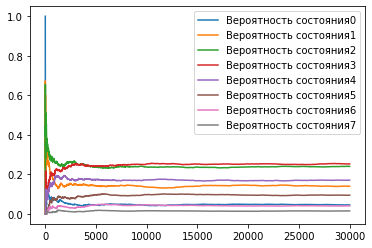

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.045205,0.045484
1,0.150682,0.139895
2,0.251137,0.240206
3,0.244161,0.252702
4,0.167562,0.171184
5,0.088858,0.094846
6,0.038396,0.040561
7,0.013998,0.015123


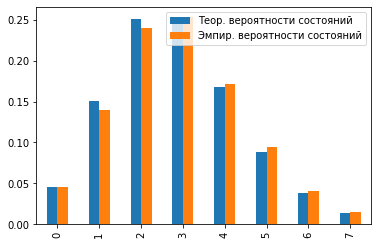

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.328667,0.328870
Вероятность отказа,0.013998,0.013389
Среднее количество заявок в СМО,2.828343,2.886604
Среднее количество заявок в очереди,1.069435,1.117466
Среднее время нахождения заявки в СМО,13.068320,13.218508
Среднее время нахождения заявки в очереди,3.208304,3.352398
Среднее количество используемых каналов,1.758908,1.769138


In [35]:
sim = Simulator(channels_cnt=2, 
              queue_size=5, 
              rq_intensity=1/3, 
              service_intensity=1/10,
              leave_intensity=1/7)
sim.full_compare()

Далее иследуем СМО при различных значениях параметров

При увеличении кол-ва каналов СМО среднее количество заявок в очереди уменьшается:

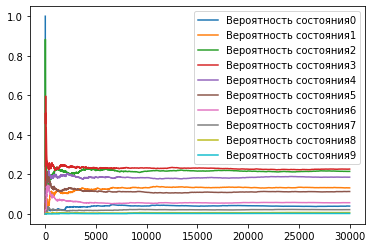

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.037323,0.039539
1,0.124411,0.131741
2,0.207352,0.215204
3,0.230391,0.226864
4,0.191992,0.185962
5,0.117890,0.113350
6,0.057308,0.056720
7,0.023055,0.021595
8,0.007911,0.006751
9,0.002367,0.002274


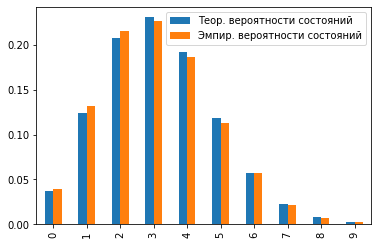

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.332544,0.332569
Вероятность отказа,0.002367,0.002292
Среднее количество заявок в СМО,3.177525,3.119298
Среднее количество заявок в очереди,0.345147,0.329948
Среднее время нахождения заявки в СМО,11.011774,10.966922
Среднее время нахождения заявки в очереди,1.035440,0.989844
Среднее количество используемых каналов,2.832378,2.789350


In [36]:
sim = Simulator(channels_cnt=4, 
              queue_size=5, 
              rq_intensity=1/3, 
              service_intensity=1/10,
              leave_intensity=1/7)
sim.full_compare()

При увеличении ограничения на время ожидания в очереди среднее количество заявок в очереди увеличивается:

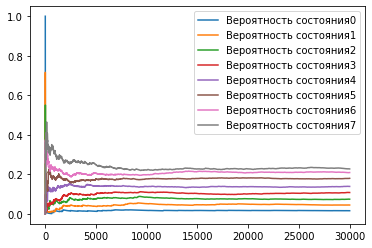

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.012098,0.016151
1,0.040328,0.044952
2,0.067214,0.074519
3,0.101839,0.108271
4,0.141443,0.139081
5,0.181337,0.179871
6,0.215877,0.209450
7,0.239864,0.227707


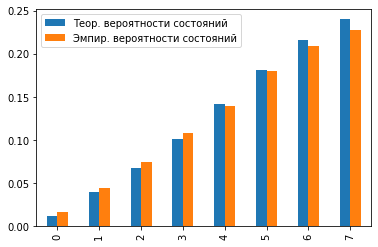

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.253379,0.244689
Вероятность отказа,0.239864,0.265933
Среднее количество заявок в СМО,4.927038,4.825121
Среднее количество заявок в очереди,2.991563,2.902375
Среднее время нахождения заявки в СМО,16.576053,16.047797
Среднее время нахождения заявки в очереди,8.974690,8.707126
Среднее количество используемых каналов,1.935475,1.922746


In [37]:
sim = Simulator(channels_cnt=2, 
              queue_size=5, 
              rq_intensity=1/3, 
              service_intensity=1/10,
              leave_intensity=1/50)
sim.full_compare()

При увеличении очереди вероятность отказа уменьшается:

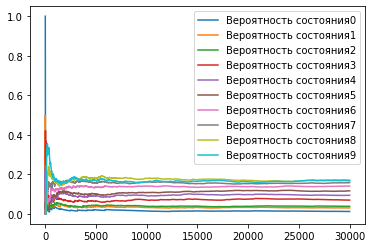

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.008094,0.012386
1,0.026979,0.030393
2,0.044964,0.038334
3,0.068128,0.069782
4,0.094622,0.094411
5,0.121310,0.116864
6,0.144417,0.141094
7,0.160464,0.158327
8,0.167150,0.171236
9,0.163872,0.167173


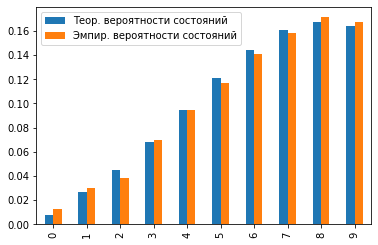

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.278709,0.286764
Вероятность отказа,0.163872,0.139709
Среднее количество заявок в СМО,6.108128,6.107668
Среднее количество заявок в очереди,4.151294,4.162833
Среднее время нахождения заявки в СМО,20.815159,21.091413
Среднее время нахождения заявки в очереди,12.453881,12.488499
Среднее количество используемых каналов,1.956834,1.944835


In [38]:
sim = Simulator(channels_cnt=2, 
              queue_size=7, 
              rq_intensity=1/3, 
              service_intensity=1/10,
              leave_intensity=1/50)
sim.full_compare()

При увеличении интенсивности потока заявок вероятность отказа увеличивается, как и среднее количество заявок в очереди

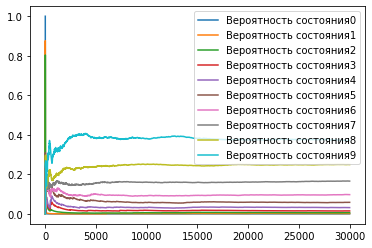

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.000483,0.000320
1,0.002416,0.001977
2,0.006040,0.006527
3,0.013727,0.015134
4,0.028598,0.031922
5,0.054996,0.058574
6,0.098208,0.097513
7,0.163680,0.165939
8,0.255750,0.249609
9,0.376102,0.372484


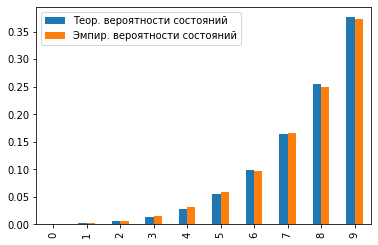

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.311949,0.296771
Вероятность отказа,0.376102,0.406457
Среднее количество заявок в СМО,7.610973,7.576870
Среднее количество заявок в очереди,5.614355,5.579487
Среднее время нахождения заявки в СМО,17.467688,17.094403
Среднее время нахождения заявки в очереди,11.228711,11.158974
Среднее количество используемых каналов,1.996618,1.997383


In [39]:
sim = Simulator(channels_cnt=2, 
              queue_size=7, 
              rq_intensity=1/2, 
              service_intensity=1/10,
              leave_intensity=1/50)
sim.full_compare()

При увеличении интенсивности потока обслуживания вероятность отказа уменьшается, как и среднее количество заявок в очереди

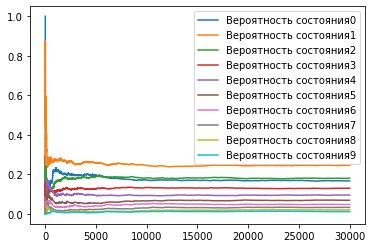

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.165477,0.166773
1,0.248215,0.245560
2,0.186162,0.181028
3,0.135555,0.129875
4,0.095911,0.095152
5,0.065994,0.069257
6,0.044192,0.047446
7,0.028821,0.033013
8,0.018319,0.020365
9,0.011354,0.011531


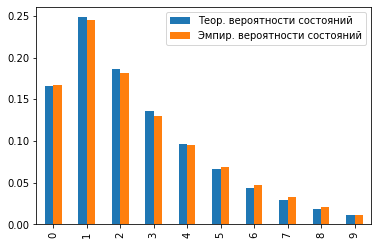

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.494323,0.494479
Вероятность отказа,0.011354,0.011041
Среднее количество заявок в СМО,2.456457,2.506601
Среднее количество заявок в очереди,1.035626,1.085707
Среднее время нахождения заявки в СМО,5.037189,5.138290
Среднее время нахождения заявки в очереди,2.071252,2.171414
Среднее количество используемых каналов,1.420831,1.420893


In [40]:
sim = Simulator(channels_cnt=2, 
              queue_size=7, 
              rq_intensity=1/2, 
              service_intensity=1/3,
              leave_intensity=1/50)
sim.full_compare()

При уменьшении интенсивности потока заявок вероятность отказа уменьшается, как и среднее количество заявок в очереди:

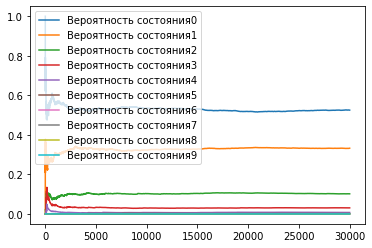

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.539718,0.525004
1,0.323831,0.332425
2,0.097149,0.101676
3,0.028296,0.030589
4,0.008008,0.007311
5,0.002204,0.001963
6,0.000590,0.000765
7,0.000154,0.000268
8,0.000039,0.000000
9,0.000010,0.000000


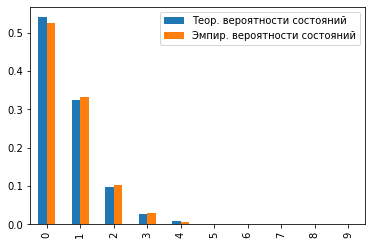

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.199998,0.199998
Вероятность отказа,0.000010,0.000010
Среднее количество заявок в СМО,0.651092,0.673065
Среднее количество заявок в очереди,0.054359,0.055498
Среднее время нахождения заявки в СМО,3.271767,3.277458
Среднее время нахождения заявки в очереди,0.271797,0.277489
Среднее количество используемых каналов,0.596733,0.617567


In [41]:
sim = Simulator(channels_cnt=2, 
              queue_size=7, 
              rq_intensity=1/5, 
              service_intensity=1/3,
              leave_intensity=1/50)
sim.full_compare()

При наличии только 1-го канала эти цифры наоборот возрастают:

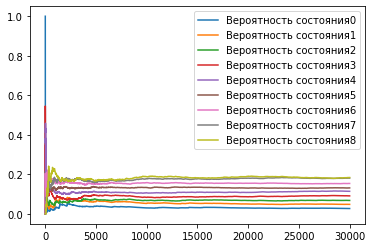

,Теор. вероятности состояний,Эмпир. вероятности состояний
0,0.031314,0.027326
1,0.046971,0.048328
2,0.066468,0.068110
3,0.089020,0.091254
4,0.113161,0.114433
5,0.136888,0.131512
6,0.157948,0.154021
7,0.174207,0.181017
8,0.184022,0.183999


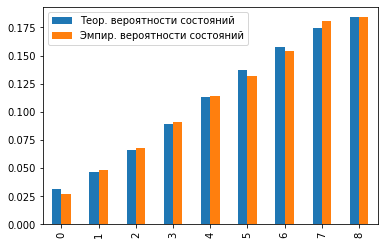

,Теор. показатели,Эмп. показатели
Абсолютная пропускная способность,0.407989,0.405330
Вероятность отказа,0.184022,0.189340
Среднее количество заявок в СМО,5.223370,5.236836
Среднее количество заявок в очереди,4.254684,4.264163
Среднее время нахождения заявки в СМО,10.957301,10.960305
Среднее время нахождения заявки в очереди,8.509367,8.528325
Среднее количество используемых каналов,0.968686,0.972674


In [42]:
sim = Simulator(channels_cnt=1, 
              queue_size=7, 
              rq_intensity=1/2, 
              service_intensity=1/3,
              leave_intensity=1/50)
sim.full_compare()